In [1]:
!pip install segmentation-models-pytorch

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
from glob import glob
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
import segmentation_models_pytorch as smp
import yaml

import os
import math
import matplotlib.pyplot as plt
import glob
import random

from torch.utils.data import Dataset, DataLoader



DataLoader

In [3]:
from glob import glob
class UAVThermicalDataset(torch.utils.data.Dataset):

    def __init__(self, yamlDataset, rootDir, typeOfRun):
        self.class_list = parseYAML(yamlDataset)
        self.imgpath_list = sorted(glob(f'{rootDir}/images/{typeOfRun}/*.jpg'))
        self.labelpath_list = sorted(glob(f'{rootDir}/labels/{typeOfRun}/*.txt'))

    def __getitem__(self, i):

        imgpath = self.imgpath_list[i]
        img = cv2.imread(imgpath)
        img = cv2.resize(img, dsize = (256, 256))
        img = img / 255
        img = torch.from_numpy(img.astype(np.float32)).clone()
        img = img.permute(2, 0, 1)

        labelpath = self.labelpath_list[i]
        rd = open(labelpath).readlines()
        label = []
        label = [[] for _ in self.class_list]
        for r in rd:
            r = r.strip()
            a = r.split(" ")
            position = [float(i) for i in a[1:]]
            label[int(a[0])].append(position)
        for k in range(len(label)):
            while len(label[k]) < 40:
                label[k].append([0,0,0,0])
        label = torch.FloatTensor(label)
        return img, label
    def __len__(self):
        return len(self.imgpath_list)



def parseYAML(yamlFile):
    with open(yamlFile) as stream:
        load = yaml.safe_load(stream)
    class_list = [load["names"][key] for key in load["names"]]
    return class_list

Classes

In [4]:
ROOT_DIR = '/content/drive/MyDrive/Colab-Notebooks/hit-uav'
train_imgs_dir = f'{ROOT_DIR}/images/train'
train_labels_dir = f'{ROOT_DIR}/labels/train'
val_imgs_dir = f'{ROOT_DIR}/images/val'
val_labels_dir = f'{ROOT_DIR}/labels/val'
test_imgs_dir = f'{ROOT_DIR}/images/test'
test_labels_dir = f'{ROOT_DIR}/labels/test'
classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']
colors = np.random.uniform(0, 255, size=(len(classes), 3))

Net

In [5]:
class myCNN(nn.Module):
    def __init__(self):
        super(myCNN, self).__init__()

        # Define the layers for your model
        self.conv1 = nn.Conv2d(3, 10, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(10, 10, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(10 * 256 * 256, 256)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(256, 5 * 40 * 4)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        x = x.view(-1, 5, 40, 4)
        return x


def NormalizeTensor(data):
    return (data - torch.min(data)) / (torch.max(data) - torch.min(data))

Clear GPU RAM

In [6]:
from numba import cuda
# all of your code and execution
try:
  cuda.select_device(0)
  cuda.close()
except Exception as e:
  print(e)

Training

In [7]:
batch_size = 10

train_dataset = UAVThermicalDataset('/content/drive/MyDrive/Colab-Notebooks/hit-uav/dataset.yaml','/content/drive/MyDrive/Colab-Notebooks/hit-uav',"train")
test_dataset = UAVThermicalDataset('/content/drive/MyDrive/Colab-Notebooks/hit-uav/dataset.yaml','/content/drive/MyDrive/Colab-Notebooks/hit-uav',"test")
val_dataset = UAVThermicalDataset('/content/drive/MyDrive/Colab-Notebooks/hit-uav/dataset.yaml','/content/drive/MyDrive/Colab-Notebooks/hit-uav',"val")

train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = myCNN()
model = model.to(device)

# hyperparameter settings
learning_rate = 0.001
epochs = 12

# loss function definition
loss_fn = nn.MSELoss()
#loss_fn = nn.NLLLoss()

TverskyLoss = smp.losses.TverskyLoss(mode = 'multilabel', log_loss = False)
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
def criterion(pred,target):
    return 0.5 * BCELoss(pred, target) + 0.5 * TverskyLoss(pred, target)
# optimizer definition
optimizer = torch.optim.Adam(model.parameters(),learning_rate) #torch.optim.SGD(model.parameters(), learning_rate)

# defining the training loop
def trainingLoop(train_dataloader, loss_fn, optimizer,val_loss_min):
    #val_loss_min = np.Inf
    validation_loss = []
    model.train()
    for batch,(x,y) in enumerate(train_dataloader):
        # move data on gpu
        x = x.to(device)
        y = y.to(device)
        # print(y.size())
        # print(x.size())
        # print(batch)
        if x.size(0) < batch_size:
            break
        pred = model(x)
        pred = pred
        y = y
        # print(pred)
        # print(y)
        # print(pred.size(0),y.size(0))
        # y = y[:pred.size(0)]
        # print(y.size(),pred.size())
        loss = loss_fn(pred,y)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss = loss.item()
        validation_loss.append(loss)
        if batch % 10 == 0:
            #print(pred[0][0][:5])

            print(f"The loss is {loss}")
            if loss < val_loss_min:
                val_loss_min = loss
                torch.save(model.state_dict(), 'semantic_segmentation.pt')
                print("Saving Changes")


    return validation_loss, val_loss_min



def testLoop(test_dataloader, loss_fn, last_loss):
    print_size = len(test_dataloader)
    num_batches = len(test_dataloader)
    test_loss = 0
    correct = 0
    val_loss_min = last_loss
    validation_accuracy = []
    validation_loss = []
    model.eval()
    with torch.no_grad():
        for batch,(x,y) in enumerate(test_dataloader):
            x,y = x.to(device), y.to(device)
            if x.size(0) < batch_size:
                break
            pred = model(x)
            pred = pred
            y = y
            # y = y[:pred.size(0)]

            loss = loss_fn(pred,y).item()
            validation_loss.append(loss)
            test_loss += loss
            corr = torch.mean((pred < 0.05).eq(y < 0.05).to(torch.float))
            #corr = (pred == y).type(torch.float).sum().item()
            validation_accuracy .append(corr)
            correct += corr
    test_loss = test_loss/num_batches
    correct = correct / print_size

    print(f"Accuracy: {correct * 100}, Average loss: {test_loss}")

    if test_loss < val_loss_min:
        val_loss_min = test_loss
        torch.save(model.state_dict(), 'semantic_segmentation.pt')
        print("Saving Changes")
    return validation_accuracy,validation_loss,val_loss_min


def createBrain():
    history_train = {
            'loss':[]
        }
    history_test = {
        'accuracy':[],
        'loss':[]
    }
    last_loss = np.inf
    for e in range(epochs):
        print(f"EPOCH {e}")
        loss,val_loss_min = trainingLoop(train_dataloader,loss_fn,optimizer,last_loss)
        last_loss = val_loss_min
        history_train['loss'].append(loss)
        acc,loss,val_loss_min = testLoop(test_dataloader,loss_fn,last_loss)
        last_loss = val_loss_min
        history_test['accuracy'].append(acc)
        history_test['loss'].append(loss)

    import json

    with open('savedata_test.json','w') as wr:
        json.dump(history_test,wr,indent=4)

    with open('savedata_train.json','w') as wr:
        json.dump(history_train,wr,indent=4)

createBrain()

cuda
EPOCH 0
The loss is 0.24399664998054504
Saving Changes
The loss is 0.09521090984344482
Saving Changes
The loss is 0.02042292058467865
Saving Changes
The loss is 0.004942985251545906
Saving Changes
The loss is 0.0071332501247525215
The loss is 0.007791014853864908
The loss is 0.006886947434395552
The loss is 0.00600713724270463
The loss is 0.004879684187471867
Saving Changes
The loss is 0.009519456885755062
The loss is 0.005173190962523222
The loss is 0.0059850383549928665
The loss is 0.003773795673623681
Saving Changes
The loss is 0.009572980925440788
The loss is 0.004492336418479681
The loss is 0.0028866438660770655
Saving Changes
The loss is 0.006509002763777971
The loss is 0.0060904561541974545
The loss is 0.0026809971313923597
Saving Changes
The loss is 0.008506064303219318
Accuracy: 93.83210754394531, Average loss: 0.0050791688544418795
EPOCH 1
The loss is 0.006853942759335041
The loss is 0.004987143911421299
The loss is 0.0054840268567204475
The loss is 0.00777330482378602
T

TypeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

cuda
Loss:  0.00044662810978479683
tensor([[[0.6992, 0.1230, 0.0172, 0.0352],
         [0.7031, 0.0205, 0.0281, 0.0371],
         [0.6359, 0.1455, 0.0312, 0.0488],
         [0.5688, 0.0342, 0.0188, 0.0332],
         [0.5305, 0.6504, 0.0234, 0.0391],
         [0.4828, 0.5840, 0.0125, 0.0391],
         [0.4125, 0.5312, 0.0375, 0.0547],
         [0.3828, 0.5596, 0.0312, 0.0410],
         [0.3992, 0.6299, 0.0234, 0.0254],
         [0.3852, 0.7070, 0.0266, 0.0391],
         [0.3297, 0.6611, 0.0188, 0.0293],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0

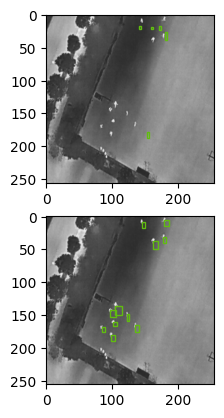

In [121]:
import matplotlib.patches as patches
import math
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = myCNN().to(device)
model.load_state_dict(torch.load("/content/semantic_segmentation.pt"))
model.eval()
val_dataloader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)

transform = transforms.ToTensor()
# for batch,(inputs,labels) in enumerate(train_dataloader):
#     if batch == 15:
#         inputs, labels = inputs, labels
inputs, labels = next(iter(train_dataloader))

# imgpath = "/content/drive/MyDrive/Colab-Notebooks/hit-uav/images/train/0_60_80_0_06631.jpg"
# img = cv2.imread(imgpath)
# img = cv2.resize(img, dsize = (256, 256))
# img = img / 255
# img = torch.from_numpy(img.astype(np.float32)).clone()
# img = img.permute(2, 0, 1)

# input = img.to(device)
# input = input.unsqueeze(0)
#print(input.size())

#print(labels)
outputs = model(inputs.to(device)).to(device)
loss = loss_fn(outputs, labels.to(device))
print("Loss: ", loss.item())
print(labels[0])
print(outputs[0])
sigmoid = nn.Sigmoid()
pred = sigmoid(outputs*2)
# pred = torch.nn.functional.one_hot(pred.long(), num_classes = len(classes)).to(torch.float32)
#print(format((pred[0]-0.5),'.2f'))
print(pred[0])
#print(pred[0, :, :, :])


pred_list = []
for cls in pred[0]:
    lst = []
    k = 0
    while cls[k][0] > 0.5 + 0.02 and cls[k][1] > 0.5 + 0.02 and (cls[k][2] > 0.5 + 0.002 and cls[k][3] > 0.5 + 0.002):
        cac = []
        for c in cls[k]:
            back = float(c)
            #normal_dist = (math.e**((-(back-0.5)*2)**2)/2)/(math.sqrt(2*math.pi))
            norm = (back-0.5)*2

            if len(cac)<2:
                if norm < 0.5:
                    norm = norm*0.9
                else:
                    norm = norm*1.1
            cac.append(norm)
        lst.append(list(cac))
        k += 1

    pred_list.append(lst)

print(pred_list)
fig,ax = plt.subplots(2)
ax[0].imshow(inputs[0, :, :, :].permute(1, 2, 0))
#fig[0].title("Predict")
ax[1].imshow(inputs[0, :, :, :].permute(1, 2, 0))
#fig[1].title("Original")

for i in range(len(pred_list)):
    for pat in pred_list[i]:
        rect = patches.Rectangle((pat[0]*255, pat[1]*255), pat[2]*255, pat[3]*255, linewidth=1, edgecolor=tuple(colors[i]/255), facecolor='none')
        ax[0].add_patch(rect)

    # while k[kk][0] != 0:
    #     print(k[kk])
    #     print((int(k[kk][0]*255), int(k[kk][1]*255)), int(k[kk][2]*255), int(k[kk][3]*255))
    #     rect = patches.Rectangle((k[kk][0]*255, k[kk][1]*255), k[kk][2]*255, k[kk][3]*255, linewidth=1, edgecolor='r', facecolor='none')
    #     ax.add_patch(rect)
    #     #plt.gca().add_patch(rect)
    #     kk += 1
for i in range(len(labels[0, :, :, :])):
    # for pat in pred_list[i]:
    #     rect = patches.Rectangle((pat[0]*255, pat[1]*255), pat[2]*255, pat[3]*255, linewidth=1, edgecolor=tuple(colors[i]/255), facecolor='none')
    #     ax.add_patch(rect)
    k = labels[0, :, :, :][i]
    kk = 0
    while k[kk][0] != 0:
        # print(k[kk])
        # print((int(k[kk][0]*255), int(k[kk][1]*255)), int(k[kk][2]*255), int(k[kk][3]*255))
        rect = patches.Rectangle((k[kk][0]*255, k[kk][1]*255), k[kk][2]*255, k[kk][3]*255, linewidth=1, edgecolor=tuple(colors[i]/255), facecolor='none')
        ax[1].add_patch(rect)
        #plt.gca().add_patch(rect)
        kk += 1
#plt.title("original_image")
#plt.axis("off")
plt.show()
